[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/juansensio/blog/blob/master/107_cfd_sh/107_cfd_sh.ipynb)

# Smith-Hutton Problem

$$
\phi_t + u \phi_x + v \phi_y = 0
$$


![](./sh.png)

In [1]:
from mesh import Face 
from dataclasses import dataclass, field
import numpy as np 

@dataclass
class DirichletBC:
	f: list[Face]
	p: list[float]
	
	def flux(self, mesh, F, vel, p):
		for f, p in zip(self.f, self.p):
			fb = mesh.f[f]
			u = np.dot(vel(fb.c.x, fb.c.y), fb.n)
			F[f] = u*p*fb.area()
		return F

@dataclass
class NeumannBC:
	f: list[Face]
	
	def flux(self, mesh, F, vel, p):
		for f in self.f:
			fb = mesh.f[f]
			u = np.dot(vel(fb.c.x, fb.c.y), fb.n)
			F[f] = u*p[fb.cells[0]]*fb.area()
		return F

In [2]:
import matplotlib.pyplot as plt

def plot(mesh, p, t):
	fig = plt.figure(figsize=(10, 5))
	ax1 = fig.add_subplot(111, projection='3d')
	mesh.plot_field(p, ax1, f't = {t:.3f}')
	plt.show()

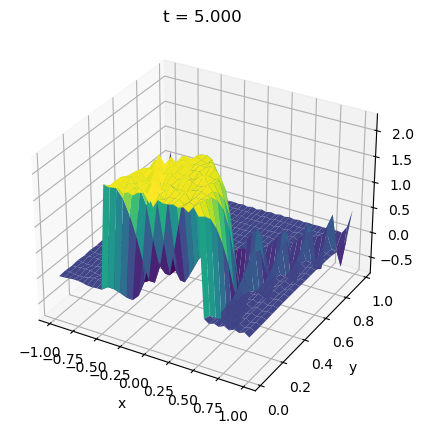

In [3]:
from mesh import Mesh
from IPython.display import clear_output
import time
import numpy as np 
import math
from fluxes import upwind, central
from temporal_schemes import euler, ab2

Nx, Ny = 40, 20
mesh = Mesh(Nx, Ny, [-1, 1], [0, 1])
p0 = np.zeros_like(mesh.c)
vel = lambda x, y: np.array([2.*y*(1-x**2), -2.*x*(1-y**2)])
ALPHA = 1e8

bcl = DirichletBC([i for i in mesh.fb if mesh.f[i].c.x == mesh.Lx[0]], [1 - math.tanh(ALPHA) for i in mesh.fb if mesh.f[i].c.x == mesh.Lx[0]])
bcr = DirichletBC([i for i in mesh.fb if mesh.f[i].c.x == mesh.Lx[1]], [1 - math.tanh(ALPHA) for i in mesh.fb if mesh.f[i].c.x == mesh.Lx[1]])
bct = DirichletBC([i for i in mesh.fb if mesh.f[i].c.x == mesh.Ly[1]], [1 - math.tanh(ALPHA) for i in mesh.fb if mesh.f[i].c.x == mesh.Ly[1]])
bcbl = DirichletBC([i for i in mesh.fb if mesh.f[i].c.y == mesh.Ly[0] and mesh.f[i].c.x < 0], [1 + math.tanh(ALPHA*(2.*mesh.f[i].c.x+1)) for i in mesh.fb if mesh.f[i].c.y == mesh.Ly[0] and mesh.f[i].c.x < 0])
bcbr = NeumannBC([i for i in mesh.fb if mesh.f[i].c.y == mesh.Ly[0] and mesh.f[i].c.x > 0])
bcs = [bcl, bcr, bcbl, bcbr]

t, tf = 0, 5
CFL = 0.5
dt = CFL*max(2/Nx, 1/Ny) / max([np.linalg.norm(vel(f.c.x, f.c.y)) for f in mesh.f])
p = p0.copy()
R = np.zeros_like(p)
it, viz_its = 0, 100

while t < tf:
	
	# update temporal
	if t + dt > tf:
		dt = tf - t
	t = t + dt
	it += 1
	# print(f't = {t:.2f}, dt = {dt:.2f}')

	# F = upwind(mesh, vel, p)
	F = central(mesh, vel, p)
	for bc in bcs:
		F = bc.flux(mesh, F, vel, p)

	# p, _ = euler(F, mesh, p, dt)
	p, R = ab2(F, mesh, p, dt, R)

	if it % viz_its == 0:
		clear_output(wait=True)
		plot(mesh, p, t)



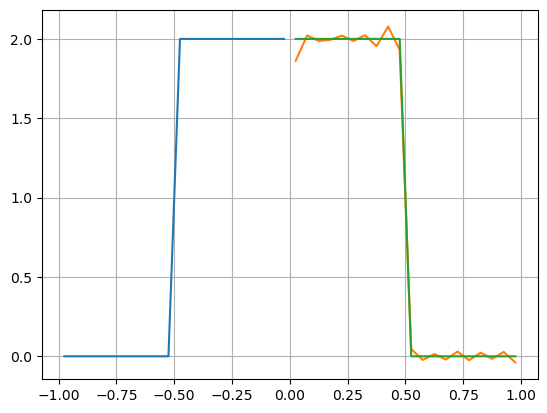

In [4]:
inp = [1 + math.tanh(ALPHA*(2.*mesh.f[f].c.x+1)) for f in bcbl.f]
plt.plot([mesh.f[f].c.x for f in bcbl.f], inp)
plt.plot([mesh.f[f].c.x for f in bcbr.f], [p[mesh.f[f].cells[0]] for f in bcbr.f])
plt.plot([mesh.f[f].c.x for f in bcbr.f], list(reversed(inp)))
plt.grid()
plt.show()

$$
u \phi_x + v \phi_y = \Gamma (\phi_{xx} + \phi_{yy})
$$

In [10]:
def flux_visc(mesh, F, vel, p, TAU):
	for i in mesh.fi:
		f = mesh.f[i]
		c0, c1 = mesh.c[f.cells[0]].c, mesh.c[f.cells[1]].c
		F[i] -= TAU*(p[f.cells[1]] - p[f.cells[0]])*f.area() / np.linalg.norm(np.array([c1.x, c1.y]) - np.array([c0.x, c0.y]))
	return F

In [11]:
@dataclass
class DirichletBC:
	f: list[Face]
	p: list[float]
	
	def flux_conv(self, mesh, F, vel, p):
		for f, p in zip(self.f, self.p):
			fb = mesh.f[f]
			u = np.dot(vel(fb.c.x, fb.c.y), fb.n)
			F[f] = u*p*fb.area()
		return F

	def flux_visc(self, mesh, F, vel, p, TAU):
		for f, _p in zip(self.f, self.p):
			fb = mesh.f[f]
			c0, c1 = mesh.c[fb.cells[0]].c, fb.c
			F[f] -= TAU*(_p - p[fb.cells[0]])*fb.area() / np.linalg.norm(np.array([c1.x, c1.y]) - np.array([c0.x, c0.y]))
		return F
	

@dataclass
class NeumannBC:
	f: list[Face]
	
	def flux_conv(self, mesh, F, vel, p):
		for f in self.f:
			fb = mesh.f[f]
			u = np.dot(vel(fb.c.x, fb.c.y), fb.n)
			F[f] = u*p[fb.cells[0]]*fb.area()
		return F

	def flux_visc(self, mesh, F, vel, p, TAU):
		for f in self.f:
			F[f] -= 0.
		return F

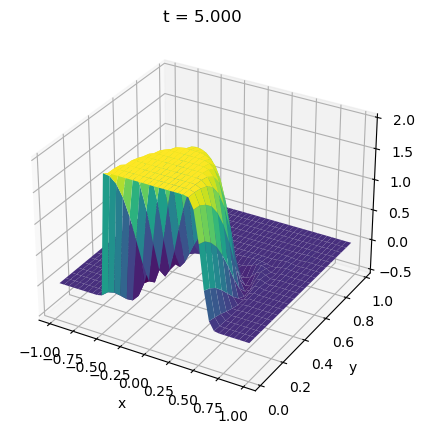

In [35]:
from mesh import Mesh
from IPython.display import clear_output
import time
import numpy as np 
import math
from fluxes import upwind, central
from temporal_schemes import euler, ab2

Nx, Ny = 40, 20
mesh = Mesh(Nx, Ny, [-1, 1], [0, 1])
p0 = np.zeros_like(mesh.c)
vel = lambda x, y: np.array([2.*y*(1-x**2), -2.*x*(1-y**2)])
ALPHA, TAU = 1e8, 1e-3

bcl = DirichletBC([i for i in mesh.fb if mesh.f[i].c.x == mesh.Lx[0]], [1 - math.tanh(ALPHA) for i in mesh.fb if mesh.f[i].c.x == mesh.Lx[0]])
bcr = DirichletBC([i for i in mesh.fb if mesh.f[i].c.x == mesh.Lx[1]], [1 - math.tanh(ALPHA) for i in mesh.fb if mesh.f[i].c.x == mesh.Lx[1]])
bct = DirichletBC([i for i in mesh.fb if mesh.f[i].c.x == mesh.Ly[1]], [1 - math.tanh(ALPHA) for i in mesh.fb if mesh.f[i].c.x == mesh.Ly[1]])
bcbl = DirichletBC([i for i in mesh.fb if mesh.f[i].c.y == mesh.Ly[0] and mesh.f[i].c.x < 0], [1 + math.tanh(ALPHA*(2.*mesh.f[i].c.x+1)) for i in mesh.fb if mesh.f[i].c.y == mesh.Ly[0] and mesh.f[i].c.x < 0])
bcbr = NeumannBC([i for i in mesh.fb if mesh.f[i].c.y == mesh.Ly[0] and mesh.f[i].c.x > 0])
bcs = [bcl, bcr, bcbl, bcbr]

t, tf = 0, 5
CFL = 0.5
dt = CFL*max(2/Nx, 1/Ny) / max([np.linalg.norm(vel(f.c.x, f.c.y)) for f in mesh.f])
p = p0.copy()
R = np.zeros_like(p)
it, viz_its = 0, 100

while t < tf:
	
	# update temporal
	if t + dt > tf:
		dt = tf - t
	t = t + dt
	it += 1
	# print(f't = {t:.2f}, dt = {dt:.2f}')

	# F = upwind(mesh, vel, p)
	F = central(mesh, vel, p)

	F = flux_visc(mesh, F, vel, p, TAU)
	for bc in bcs:
		F = bc.flux_conv(mesh, F, vel, p)
		F = bc.flux_visc(mesh, F, vel, p, TAU)

	# p, _ = euler(F, mesh, p, dt)
	p, R = ab2(F, mesh, p, dt, R)

	if it % viz_its == 0:
		clear_output(wait=True)
		plot(mesh, p, t)



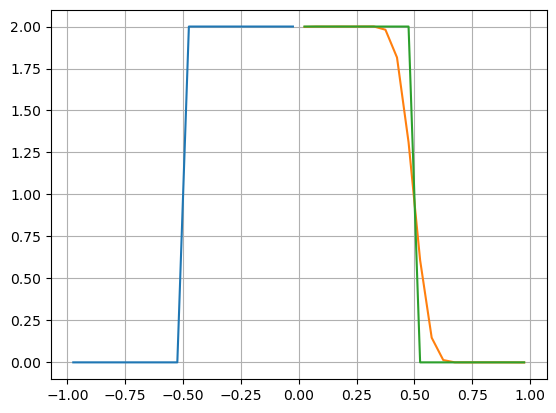

In [36]:
inp = [1 + math.tanh(ALPHA*(2.*mesh.f[f].c.x+1)) for f in bcbl.f]
plt.plot([mesh.f[f].c.x for f in bcbl.f], inp)
plt.plot([mesh.f[f].c.x for f in bcbr.f], [p[mesh.f[f].cells[0]] for f in bcbr.f])
plt.plot([mesh.f[f].c.x for f in bcbr.f], list(reversed(inp)))
plt.grid()
plt.show()